In [ ]:
import pandas as pd
import numpy as np
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
nlp = spacy.load('en_core_web_sm')

In [3]:
df = pd.read_csv('sample-data.csv')
print(f"Nombre de produits: {len(df)}")
print(df.head())

Nombre de produits: 500
   id                                        description
0   1  Active classic boxers - There's a reason why o...
1   2  Active sport boxer briefs - Skinning up Glory ...
2   3  Active sport briefs - These superbreathable no...
3   4  Alpine guide pants - Skin in, climb ice, switc...
4   5  Alpine wind jkt - On high ridges, steep ice an...


In [24]:
# 3. Prétraitement textuel avec spacy: nettoyage, stopwords, lemmatisation
def preprocess(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return " ".join(tokens)

df['clean_desc'] = df['description'].apply(preprocess)

In [26]:
# 3. Encodage TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # limite max features pour accélérer
tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_desc'])

print("TF-IDF matrix shape:", tfidf_matrix.shape)

TF-IDF matrix shape: (500, 3534)


In [40]:
# 5. Clustering avec DBSCAN (distance cosinus)
# DBSCAN ne supporte pas directement 'cosine' dans sklearn, mais on peut passer la matrice TF-IDF normalisée
from sklearn.metrics.pairwise import cosine_distances

dbscan = DBSCAN(eps=0.4, min_samples=3, metric='cosine')
clusters = dbscan.fit_predict(tfidf_matrix)

df['cluster'] = clusters
print("Nombre de clusters (hors outliers -1):", len(set(clusters)) - (1 if -1 in clusters else 0))
print(df['cluster'].value_counts())

Nombre de clusters (hors outliers -1): 27
cluster
-1     363
 13     15
 9      12
 8       8
 1       7
 0       7
 17      6
 22      6
 18      6
 2       5
 20      5
 10      5
 23      4
 19      4
 15      4
 6       4
 4       4
 3       4
 12      4
 5       3
 7       3
 26      3
 11      3
 14      3
 16      3
 21      3
 24      3
 25      3
Name: count, dtype: int64


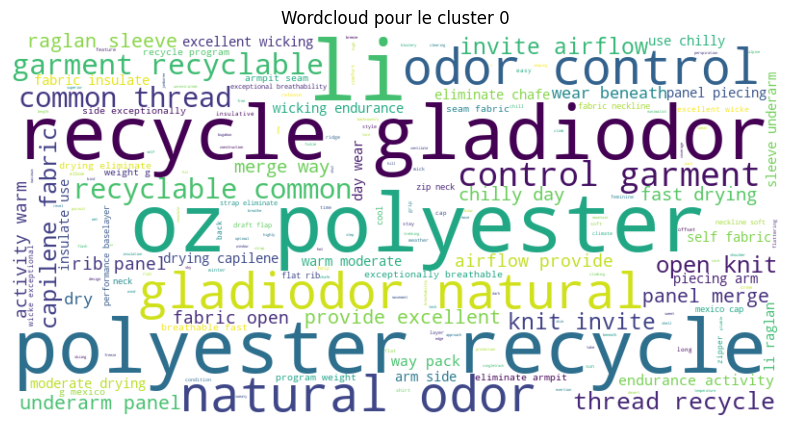

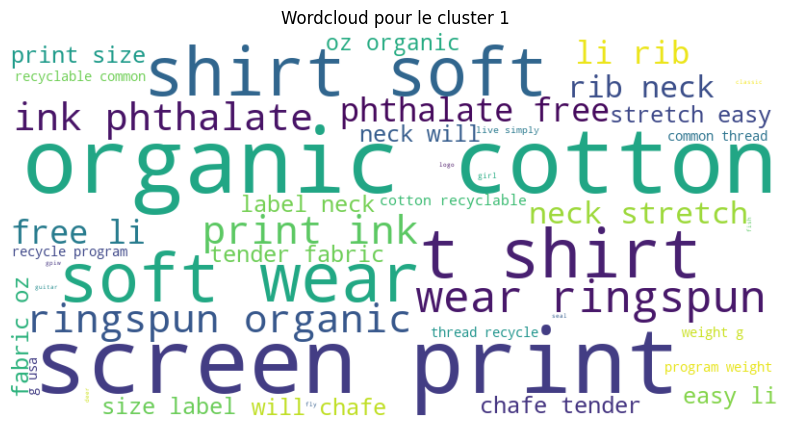

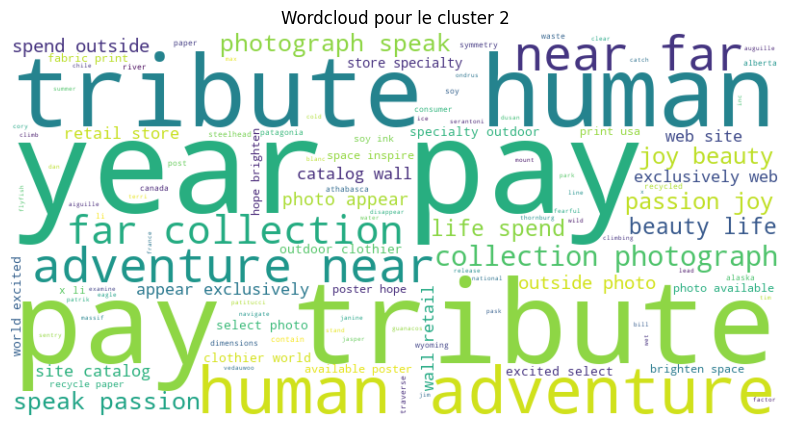

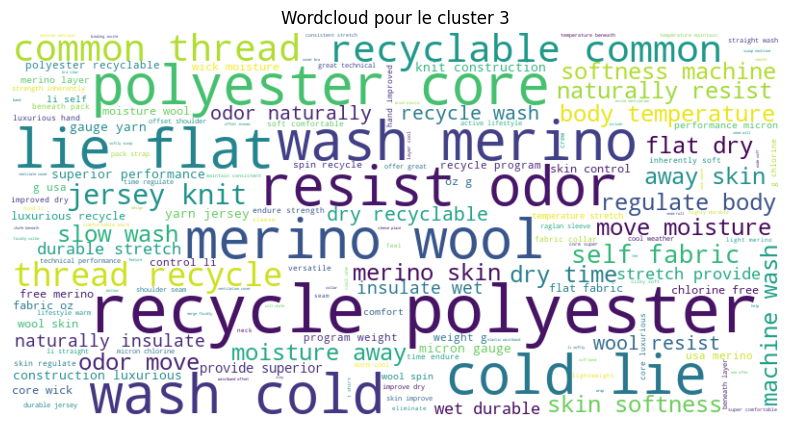

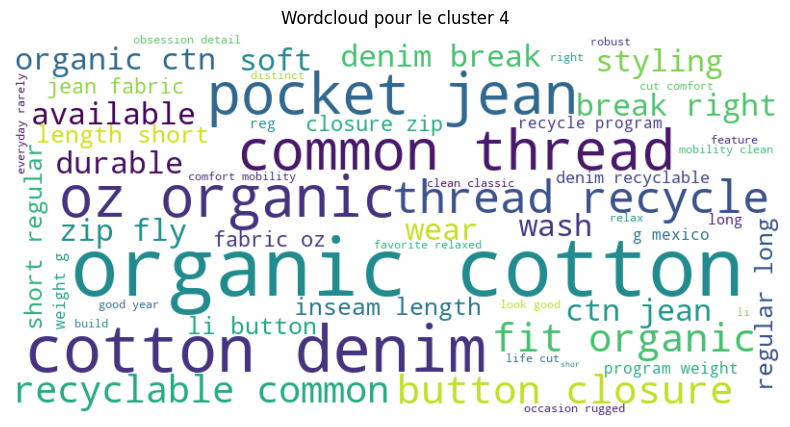

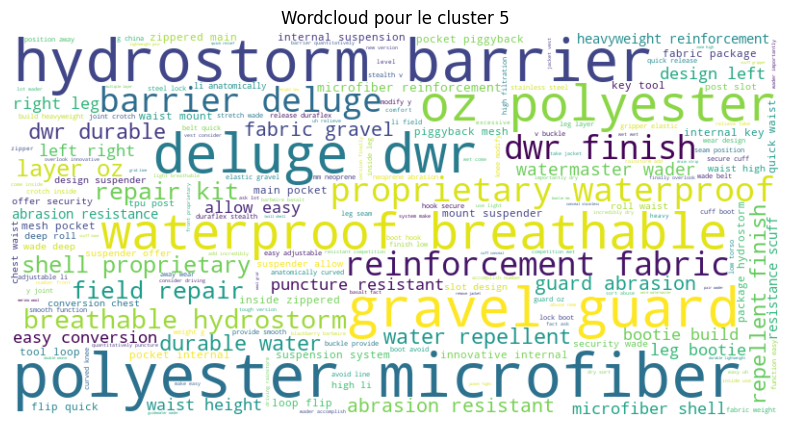

In [11]:
# 6. Visualisation wordcloud par cluster
def plot_wordcloud_for_cluster(cluster_id):
    texts = df.loc[df['cluster'] == cluster_id, 'clean_desc']
    combined_text = " ".join(texts)
    wc = WordCloud(width=800, height=400, background_color='white').generate(combined_text)
    plt.figure(figsize=(10,5))
    plt.title(f'Wordcloud pour le cluster {cluster_id}')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

for cluster_id in sorted(set(clusters)):
    if cluster_id == -1:
        continue  # outliers
    plot_wordcloud_for_cluster(cluster_id)

In [28]:
def find_similar_items(item_id):
    try:
        cluster_id = df.loc[df['id'] == item_id, 'cluster'].values[0]
    except IndexError:
        print(f"Produit {item_id} non trouvé.")
        return []
    if cluster_id == -1:
        print("Ce produit est un outlier et n'a pas de cluster similaire.")
        return []
    similar = df[(df['cluster'] == cluster_id) & (df['id'] != item_id)]
    return similar['id'].head(5).tolist()

In [42]:
item_input = input("Entrez l'id du produit: ")

try:
    item_input_int = int(item_input)
except ValueError:
    print("L'id doit être un nombre entier.")
    item_input_int = None

if item_input_int is not None:
    if item_input_int not in df['id'].values:
        print("Produit non trouvé, veuillez vérifier l'id.")
    else:
        similar_items = find_similar_items(item_input_int)
        print(f"Produits similaires à {item_input_int}: {similar_items}")

Produits similaires à 89: [87, 88, 90, 200, 201]


In [35]:
# 8. Topic modeling avec TruncatedSVD (LSA)
n_topics = 15
svd = TruncatedSVD(n_components=n_topics, random_state=42)
topic_encoded = svd.fit_transform(X_tfidf)

In [36]:
# Sauvegarder dans dataframe
topic_encoded_df = pd.DataFrame(topic_encoded, index=df.index, columns=[f"topic_{i}" for i in range(n_topics)])

In [38]:
topic_encoded_df['main_topic'] = topic_encoded_df.idxmax(axis=1)

df = pd.concat([df, topic_encoded_df], axis=1)

print("Aperçu des topics pour chaque produit:")
print(df[['id', 'main_topic']].head())

Aperçu des topics pour chaque produit:
   id main_topic main_topic
0   1    topic_0    topic_0
1   2    topic_0    topic_0
2   3    topic_0    topic_0
3   4    topic_0    topic_0
4   5    topic_0    topic_0


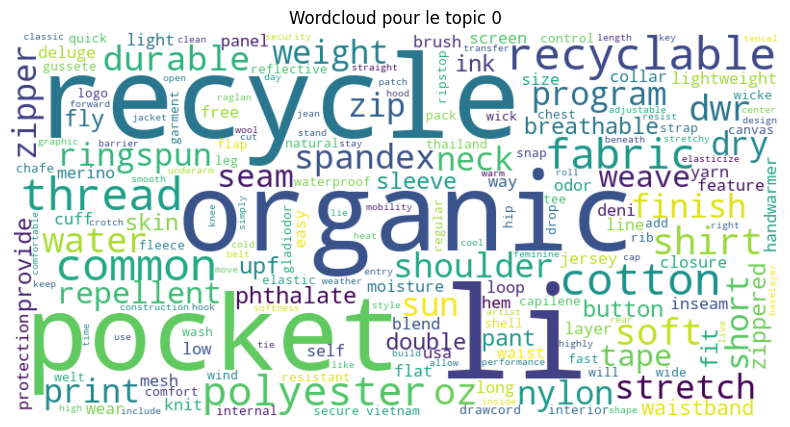

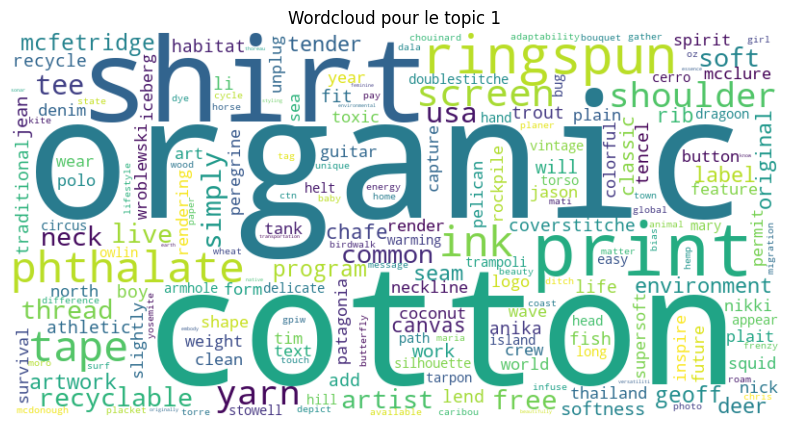

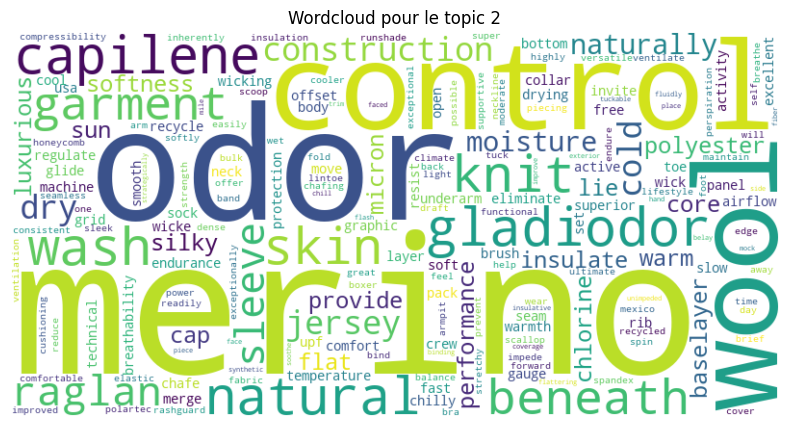

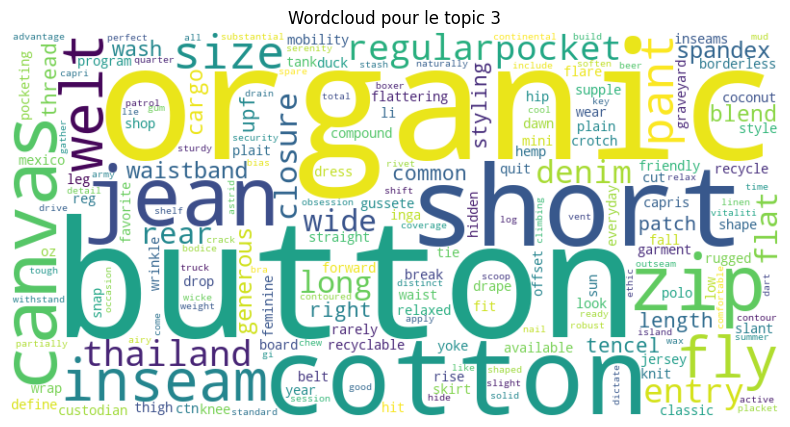

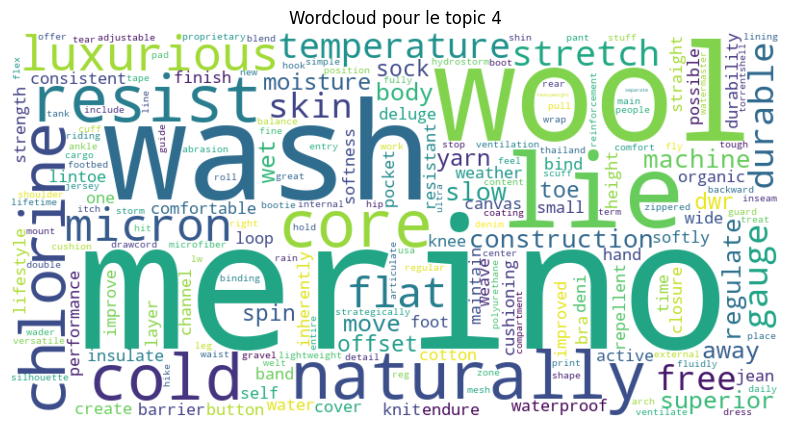

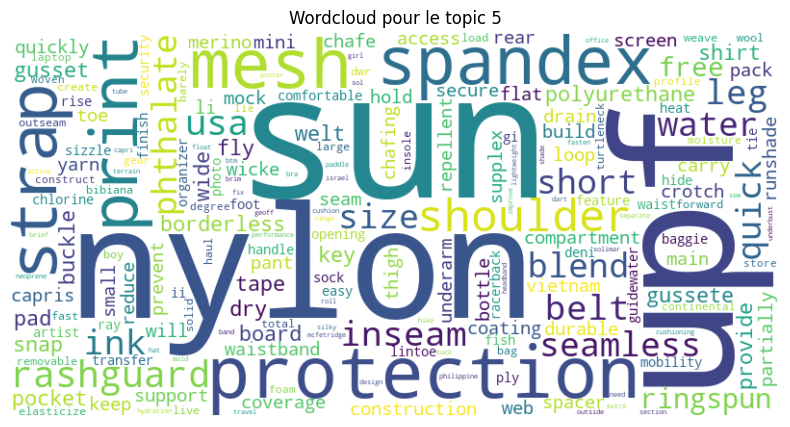

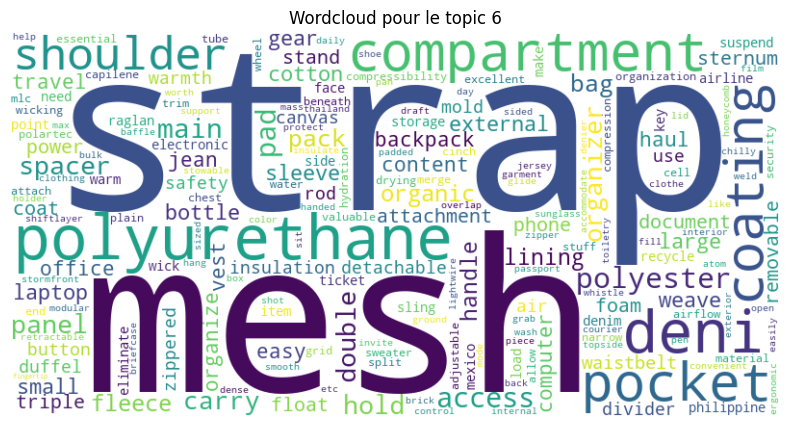

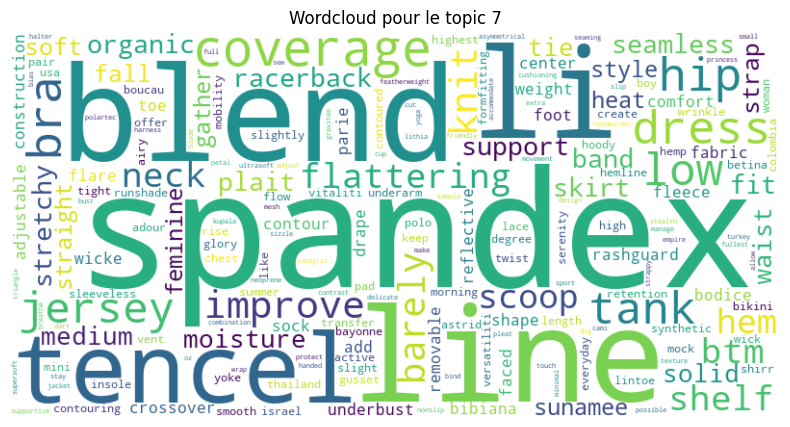

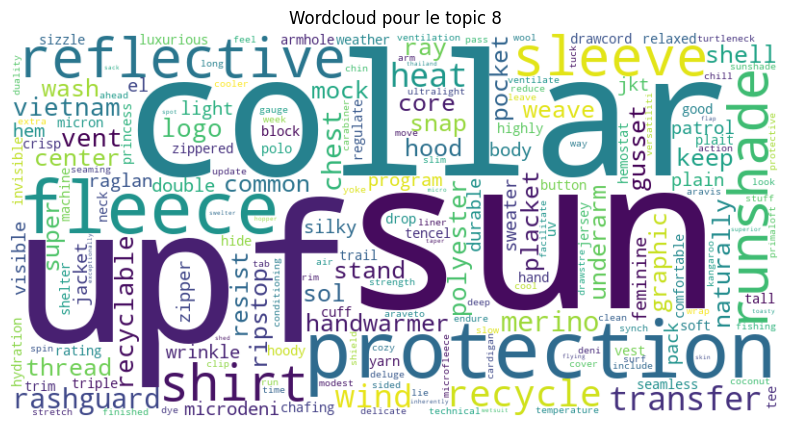

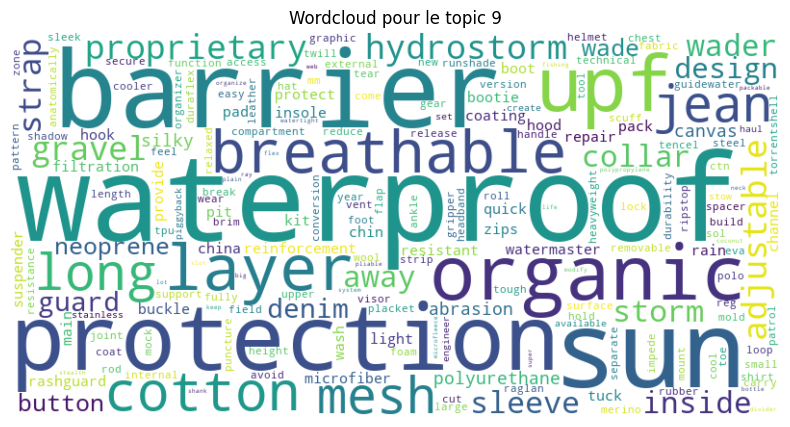

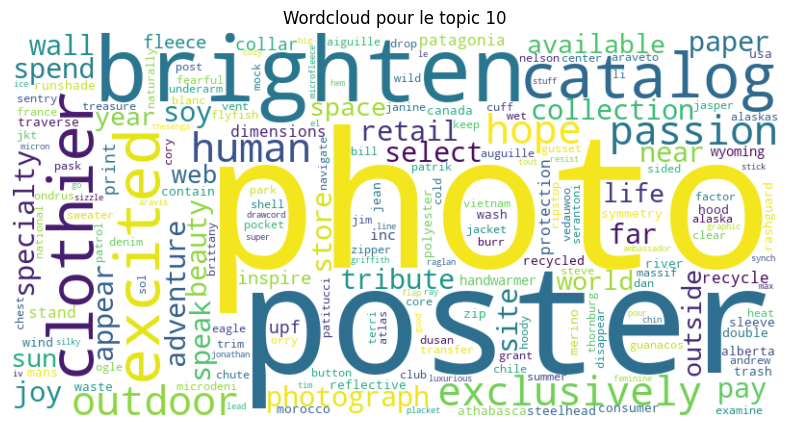

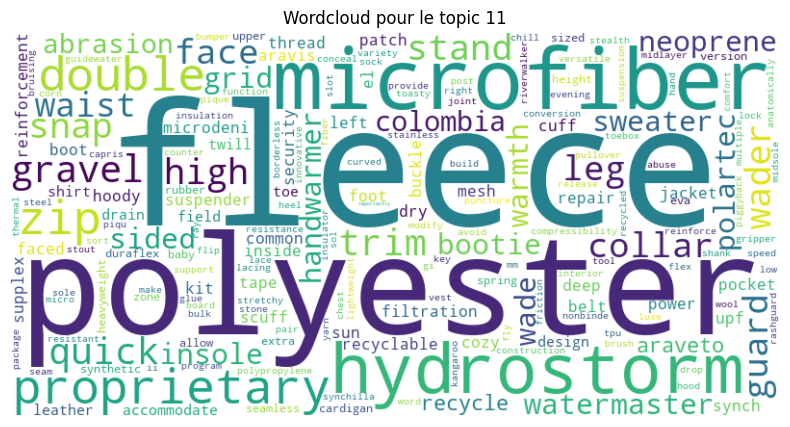

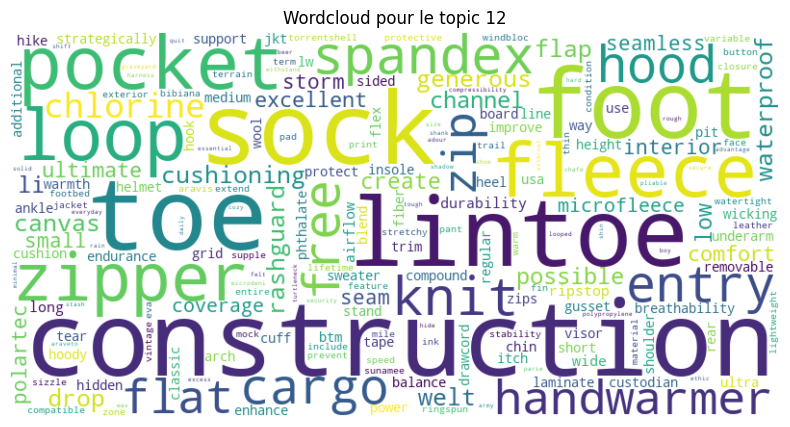

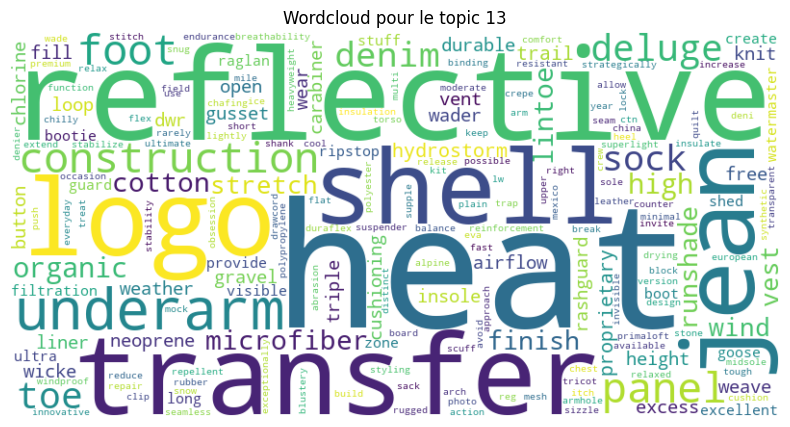

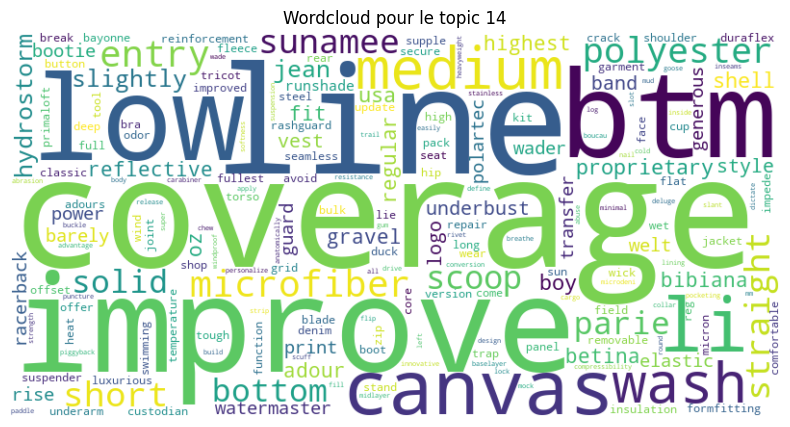

In [39]:
# 9. Wordcloud pour chaque topic
terms = tfidf.get_feature_names_out()

def plot_wordcloud_for_topic(topic_idx):
    comp = svd.components_[topic_idx]
    terms_weights = dict(zip(terms, comp))
    wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(terms_weights)
    plt.figure(figsize=(10,5))
    plt.title(f'Wordcloud pour le topic {topic_idx}')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

for i in range(n_topics):
    plot_wordcloud_for_topic(i)